# FT_SOMMELIER

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
red_wine_df = pd.read_csv("/nfs/2018/t/tholzheu/42_program/git_ft_sommelier/resources/winequality-red.csv", sep=';')
white_wine_df = pd.read_csv("/nfs/2018/t/tholzheu/42_program/git_ft_sommelier/resources/winequality-white.csv", sep=';')

# my computer

#red_wine_df = pd.read_csv("/home/thomas/42/github/ft_sommelier/resources/winequality-red.csv", sep=';')
#white_wine_df = pd.read_csv("/home/thomas/42/github/ft_sommelier/resources/winequality-white.csv", sep=';')

In [3]:
print(len(red_wine_df))
red_wine_df.head()

1599


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [4]:
white_wine_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


### V.1 Exploring the green reds

#### a) Plot scatter matrix function

In [5]:
def plot_scatter_matrix(wine_data, good_threshold, bad_threshold, save_plot=False, name=''):
    fig, axmat = plt.subplots(12, 12, figsize=(20, 20))
    for axrow in axmat:
        for ax in axrow:
            ax.set_xticks([])
            ax.set_yticks([])
    plt.subplots_adjust(wspace=0, hspace=0)
    h_list = red_wine_df.columns.values
    for i in range(len(h_list)):
        for j in range(len(h_list)):
            plt.sca(axmat[i][j])
            if (i == j):
                plt.text(0.5, 0.5, h_list[j].replace(' ', '\n'), fontsize=16, ha='center', va='center')
            else:
                plt.scatter(red_wine_df[h_list[j]][red_wine_df['quality'] > good_threshold],
                            red_wine_df[h_list[i]][red_wine_df['quality'] > good_threshold], s=3, c='g')
                plt.scatter(red_wine_df[h_list[j]][red_wine_df['quality'] < bad_threshold],
                            red_wine_df[h_list[i]][red_wine_df['quality'] < bad_threshold], s=3, c='m')
    if (save_plot):
        plt.savefig(name + 'Plt.png') # bbox_inches='tight' to remove white space around
    plt.show()

In [ ]:
plot_scatter_matrix(red_wine_df, 7, 4)

#### b) Which factors do you think will be most useful for distinguishing high vs low quality wines

At a first glance I see that sulphates and alcohol have a clearer division when it comes to quality.
We can see in the figure that in most cases a higher alcohol quantity and a higher level of sulphates results
in a beter quality wine. This is the case when comparing high quality wines (8 or higher) vs low quality wines
(3 or lower)

### V.2 Learning to perceptron

#### a) & b) Perceptron implementation and training

In [6]:
import random

def heaviside_step_fn(nb):
    if (nb < 0):
        return (0)
    elif (nb >= 0):
        return (1)

def dot_prod(v1, v2):
    return (sum([x * y for x, y in zip(v1, v2)]))

def vec_add(v1, v2):
    return ([round(x + y, 2) for x, y in zip(v1, v2)])
    
def vec_sub(v1, v2):
    return ([round(x - y, 2) for x, y in zip(v1, v2)])

def vec_scale(v, scalar):
    return ([i * scalar for i in v])

def select_features_labels(df):
    tmp = red_wine_df[['pH', 'density', 'quality']][(red_wine_df['quality'] >= 8) | (red_wine_df['quality'] <=3)]
    tmp['quality'].where(tmp['quality'] <= 3, 1, inplace=True) # Replace quality 8 and above with 1
    tmp['quality'].where(tmp['quality'] == 1, 0, inplace=True) # and quality 3 and below with 0
    features = tmp[['pH', 'density']]
    labels = tmp[['quality']]
    features = [list(features[item]) for item in features]
    labels = [list(labels[item]) for item in labels]
    labels = labels[0]
    return (features, labels) # returns a list of lists containing the values of each feature

def update_weights(w, x, y, l_rate):
    update = False
    if (heaviside_step_fn(dot_prod(w, x)) == 1 and y == 0):
        update = True
        w = vec_sub(w, vec_scale(x, l_rate)) # w = w - lr * x
    elif (heaviside_step_fn(dot_prod(w, x)) == 0 and y == 1):
        update = True
        w = vec_add(w, vec_scale(x, l_rate)) # w = w + lr * x
    return (w, update)
    
def perceptron_trainer(wine_data, l_rate, epochs):
    features, labels = select_features_labels(wine_data)
    train_until_convergence = False
    epoch_count = 0
    info = []
    if (epochs == 0):
        train_until_convergence = True # train until convergence if epochs is 0
        epochs = 1 # epoch_count < epochs so it enter the loop
    converged = False
    w = [0, 0, 0] # w[0] is the bias
    for i in range(3):
        w[i] = round(random.uniform(-4, 4), 2) # init random weights between -4 and 4
    while (not converged and epoch_count < epochs):
        converged = True
        errors_at_epoch = 0
        for x1, x2, y in zip(features[0], features[1], labels):
            x = [1, x1, x2]
            w, update = update_weights(w, x, y, l_rate)
            if (update == True): # if there was no update in the whole dataset that means our model has converged
                converged = False
                errors_at_epoch += 1
        info.append((epoch_count, errors_at_epoch, w))
        epoch_count += 1
        if (train_until_convergence == True):
            epochs = epoch_count + 1 # we don't want to stop training until convergence
    return (info)

In [7]:
info = perceptron_trainer(red_wine_df, l_rate=0.9, epochs=20000)

#### c) Plot perceptron performance

In [87]:
def plot_perceptron_performance(wine_data, info, good_threshold, bad_threshold, epoch=-1, save_plot=False, name=''):
    fig, axvec = plt.subplots(1, 2, figsize=(15, 5))
    if (epoch >= 0):
        info = info[: epoch + 1]
    else:
        epoch = info[-1][0]
    df = pd.DataFrame(info)
    
    plt.sca(axvec[0])
    plt.plot(df[0], df[1])
    plt.xlabel('epoch')
    plt.ylabel('classification errors')
    plt.title('Error as a function of epoch')
    
    plt.sca(axvec[1])
    good = plt.scatter(red_wine_df['alcohol'][red_wine_df['quality'] > good_threshold],
                red_wine_df['pH'][red_wine_df['quality'] > good_threshold], s=15, c='g')
    bad = plt.scatter(red_wine_df['alcohol'][red_wine_df['quality'] < bad_threshold],
                red_wine_df['pH'][red_wine_df['quality'] < bad_threshold], s=15, c='m')
    plt.legend((good, bad), ('good wines (> %d score)' % good_threshold, 'bad wines (< %d score)' % bad_threshold), loc=(1.01, 0.88))
    plt.xlabel('alcohol')
    plt.ylabel('pH')
    plt.title('Decision boundary on epoch %d' % epoch )
    x_list = list(range(8, 15))
    w = info[-1][2]
    #y = (-1 * w[1] / w[2]) * x_list + (-1 * w[0] / w[2]) # this is just math. source: https://medium.com/@thomascountz/calculate-the-decision-boundary-of-a-single-perceptron-visualizing-linear-separability-c4d77099ef38
    #plt.plot(x_list, y)
    
    plt.show()

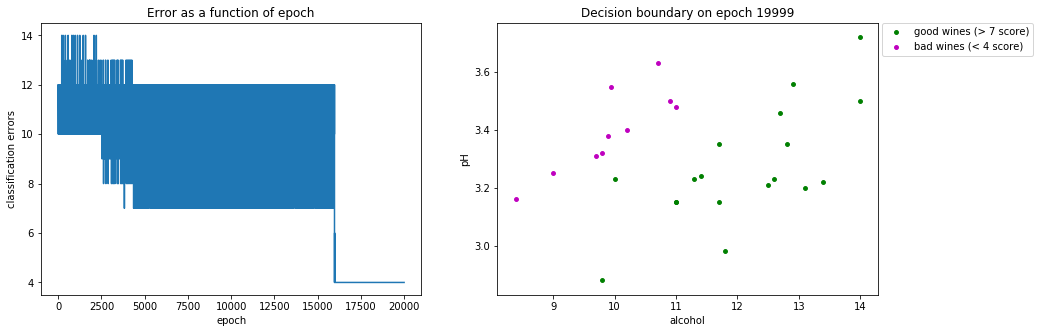

In [88]:
plot_perceptron_performance(red_wine_df, info, 7, 4)